In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from methods import get_result_data, get_autoregrmatrix

import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
import scipy as sc 
import os

from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_predict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy
import warnings
%matplotlib inline 

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")
data = data[["aqi", "Date"]]
data = data.set_index('Date').sort_index()

In [ ]:
x_train = data["aqi"]['2013-01-01':'2018-01-01']
x_test = data["aqi"]['2018-01-02':'2020-12-31']

Для наглядности нарисуем данные за последние два года в x_train.

<AxesSubplot: xlabel='Date'>

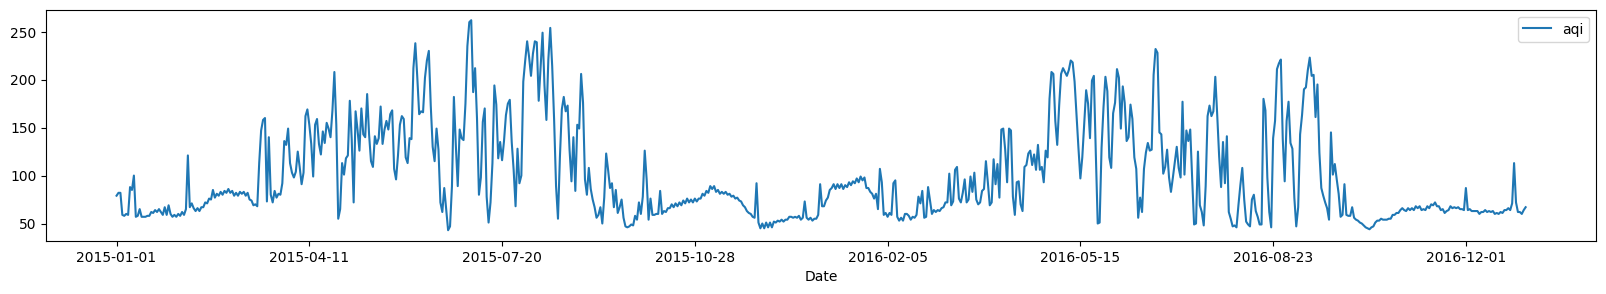

In [ ]:
x_train['2015-01-01':'2017-01-01'].plot(figsize=(20, 3))

### Напишем функцию для предсказания индекса качества воздуха. Для предсказания на n дней вперёд, будем брать среднее за n дней по имеющимся у нас данным. Это будет наш Baseline.

In [ ]:
# Baseline mean value for n steps behind
def predict_mean_value(data, x_test, steps):
    mean_value = int(data['aqi'].tail(steps).mean())
    return x_test[:steps], np.stack([mean_value for i in range(steps)])

Измерим ошибку за 10, 30, 60 дней.

In [ ]:
y_test, y_predict = predict_mean_value(data, x_test, 10)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 126.6', 'MAE: 8.6')

In [ ]:
y_test, y_predict = predict_mean_value(data, x_test, 30)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 136.86666666666667', 'MAE: 10.4')

In [ ]:
y_test, y_predict = predict_mean_value(data, x_test, 60)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 126.85', 'MAE: 9.083333333333334')

Можно отметить, что ошибка не сильно возрастает со временем.

### Попробуем обучить LinearRegression. В качестве регрессоров будем брать значения за предыдущие 10 дней, каждый раз сдвигая день на 1.

In [ ]:
# Пример матрицы
example_reg_matrix, _ = get_autoregrmatrix(x_train, 10, 10)
example_reg_matrix[:10]

array([[125,  79,  67,  62,  57,  55,  55,  56,  54,  64],
       [ 79,  67,  62,  57,  55,  55,  56,  54,  64,  52],
       [ 67,  62,  57,  55,  55,  56,  54,  64,  52,  51],
       [ 62,  57,  55,  55,  56,  54,  64,  52,  51,  53],
       [ 57,  55,  55,  56,  54,  64,  52,  51,  53,  61],
       [ 55,  55,  56,  54,  64,  52,  51,  53,  61,  66],
       [ 55,  56,  54,  64,  52,  51,  53,  61,  66,  71],
       [ 56,  54,  64,  52,  51,  53,  61,  66,  71,  72],
       [ 54,  64,  52,  51,  53,  61,  66,  71,  72,  71],
       [ 64,  52,  51,  53,  61,  66,  71,  72,  71,  71]])

In [ ]:
def linear_regression_predict(x_train, x_test, delay, regressors=10):
    K = regressors
    h = delay # delay (горизонn прогнозирования)

    X_train, y_train = get_autoregrmatrix(x_train,h,K)
    X_test, y_test = get_autoregrmatrix(x_test,h,K)
    
    linear_regression = LinearRegression()
    linear_regression.fit(X_train,y_train)
    linear_regression_predict = linear_regression.predict(X_test)
    
    return y_test, linear_regression_predict

Обучим LinearRegression и Измерим ошибку за 10, 30, 60 дней.

In [ ]:
y_test, y_predict = linear_regression_predict(x_train, x_test, 10)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 1758.8154222765988', 'MAE: 31.86965746436323')

In [ ]:
y_test, y_predict = linear_regression_predict(x_train, x_test, 30)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 2196.4385177557324', 'MAE: 36.54395915339661')

In [ ]:
y_test, y_predict = linear_regression_predict(x_train, x_test, 60)
f"MSE: {mean_squared_error(y_test, y_predict)}", f"MAE: {mean_absolute_error(y_test, y_predict)}"

('MSE: 2564.2135994601354', 'MAE: 42.2463020255189')

In [ ]:
from scipy import stats
from copy import deepcopy
x_train = data['2013-01-01':'2018-01-01']
x_test = data['2013-01-01':'2018-01-01']
boxcox_x_train = deepcopy(x_train)

_, lmbda = stats.boxcox(x_train["aqi"])

<AxesSubplot: xlabel='Date'>

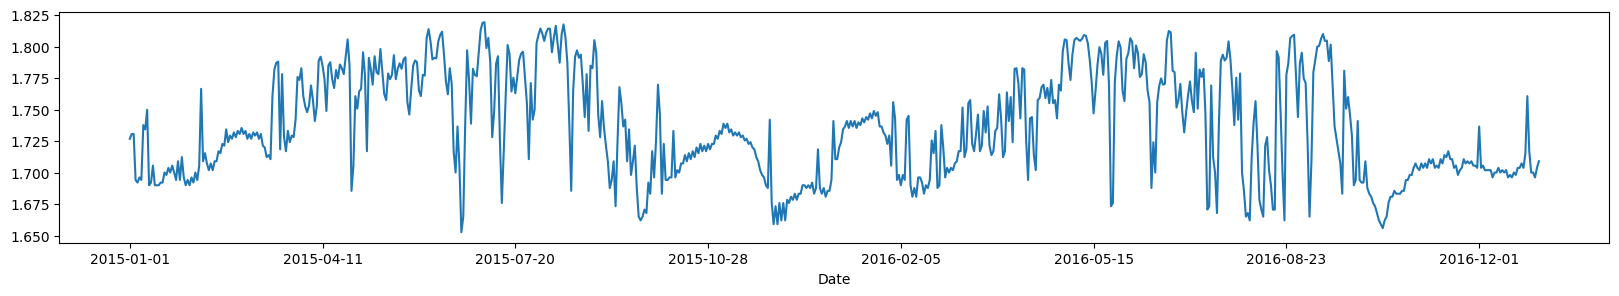

In [ ]:
boxcox_x_train["box_cox_aqi"] = stats.boxcox(x_train['aqi'])[0]
boxcox_x_train['2015-01-01':'2017-01-01']["box_cox_aqi"].plot(figsize=(20, 3))

In [ ]:
# seasonal differencing
boxcox_x_train["box_cox_aqi"] = np.log(x_train['aqi'])
p = 365

sdiff_boxcox_x_train = (boxcox_x_train['box_cox_aqi'] - boxcox_x_train['box_cox_aqi'].shift(p))[p:]

In [ ]:
# Augmented Dickey-Fuller unit root test
# H0: ts is not stationary
df_stat = stattools.adfuller(np.array(sdiff_boxcox_x_train))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))

The Augmented Dickey-Fuller test statistic -6.705303, 
pvalue: 0.00 
maximal Lag: 22 
critical values: {'1%': -3.4349024693573584, '5%': -2.8635506057382325, '10%': -2.5678404322793846}


In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
# H0: ts is stationary
kpss_stat= stattools.kpss(np.array(sdiff_boxcox_x_train))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.606517, 
pvalue: 0.02 
maximal Lag: 21 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


После статтестов, можем сделать вывод, что временной ряд стационарен.

In [239]:
model_sarimax = sm.tsa.statespace.SARIMAX(boxcox_x_train["box_cox_aqi"] , order=(3, 1, 1), seasonal_order=(1, 0, 0, 12)).fit(disp=-1)

/home/dmitry/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/dmitry/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [240]:
print(model_sarimax.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         box_cox_aqi   No. Observations:                 1827
Model:             SARIMAX(3, 1, 1)x(1, 0, [], 12)   Log Likelihood                  56.931
Date:                             Fri, 23 Dec 2022   AIC                           -101.862
Time:                                     00:46:13   BIC                            -68.803
Sample:                                 01-01-2013   HQIC                           -89.668
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6377      0.025     25.901      0.000       0.589       0.686
ar.L2         -0.1507      

Autocorrelation test

/home/dmitry/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


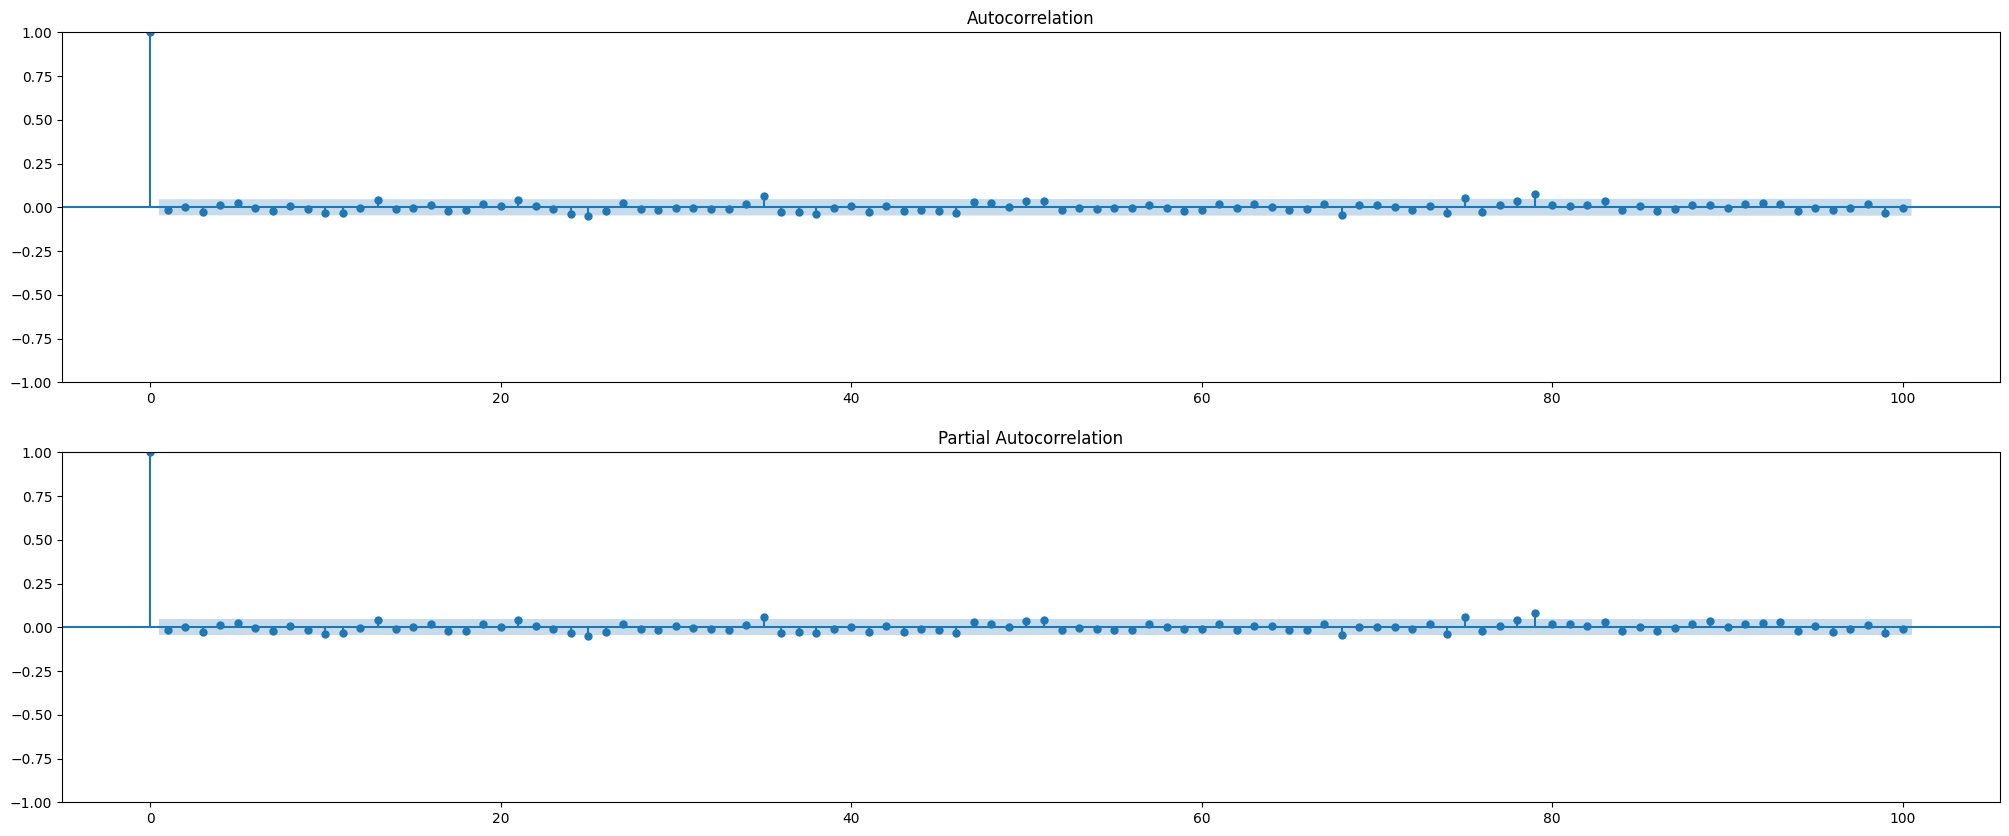

In [241]:
fig = plt.figure(figsize=[25,10])
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_sarimax.resid.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_sarimax.resid.values.squeeze(), lags=100, ax=ax2)

In [242]:
# # Ljung-Box test 
sm.stats.acorr_ljungbox(model_sarimax.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,6.456944,0.775524


lb_pvalue - остатки являются независимыми